In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from matplotlib import colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
adata = sc.read_h5ad('scRNAseq_pancan_normalized_after_scanvi.h5ad')

In [4]:
Immune_cat = ['Lymphocyte','Plasma','Myeloid']

In [5]:
adata = adata[adata.obs['Celltype1'].isin(Immune_cat),:].copy()
adata

AnnData object with n_obs × n_vars = 551765 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'DataID_colors', 'Organ_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

# Celltyepist

In [6]:
import celltypist
from celltypist import models

In [7]:
model = models.Model.load(model = 'Immune_All_Low.pkl')

In [8]:
model

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [9]:
pred =celltypist.annotate(adata, model='Immune_All_Low.pkl', majority_voting=True)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 551765 cells and 14090 genes
🔗 Matching reference genes in the model
🧬 4805 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [10]:
pred

CellTypist prediction result for 551765 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 551765 query cells and 98 cell types
    probability_matrix: data frame with 551765 query cells and 98 cell types
    adata: AnnData object referred

In [11]:
adata2 = pred.to_adata()
adata2

AnnData object with n_obs × n_vars = 551765 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'DataID_colors', 'Organ_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'umap', 'leiden'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

# Cell type cleaning

In [30]:
ct_list = pd.read_csv("Celltypist_celltype.csv")
ct_list

,majority_voting,new_name
0,Tem/Trm cytotoxic T cells,T
1,Macrophages,Macrophage
2,Regulatory T cells,T
3,Tem/Effector helper T cells,T
4,CD16+ NK cells,NK_cell
5,Tcm/Naive helper T cells,T
6,Memory B cells,B_cell
7,Tem/Temra cytotoxic T cells,T
8,Classical monocytes,Monocyte
9,CD16- NK cells,NK_cell


In [36]:
adata2.obs['Celltype2'] = adata2.obs['majority_voting'].map(dict(zip(ct_list['majority_voting'],ct_list['new_name'])))
adata2.write_h5ad('scRNAseq_Immune_cells_normalized_clinic_corr_celltypist.h5ad')

# CD4&CD8

In [121]:
adata = adata2[adata2.obs['Celltype2']=="T",:].copy()
adata

AnnData object with n_obs × n_vars = 305307 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'Celltype2'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'DataID_colors', 'Organ_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'Celltype2_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [100]:
ref_cd8 = sc.read_h5ad('Pan_Tcell_MDanderson/CD8.h5ad')
ref_cd8


AnnData object with n_obs × n_vars = 110218 × 70777
    obs: 'cell.type', 'TissueType', 'CancerType', 'batch'
    var: 'features'

In [107]:
mapping = {
    0: 'CD8_c0_t-Teff',
    1: 'CD8_c1_Tex',
    2: 'CD8_c2_Teff',
    3: 'CD8_c3_Tn',
    4: 'CD8_c4_Tstr',
    5: 'CD8_c5_Cisg',
    6: 'CD8_c6_Tcm',
    7: 'CD8_c7_Tn_p-Tex',
    8: 'CD8_c8_Teff_KLRG1',
    9: 'CD8_c9_Tsen',
    10: 'CD8_c10_Teff_CD244',
    11: 'CD8_c11_Teff_SEMA4A',
    12: 'CD8_c12_Trm',
    13: 'CD8_c13_Tn_Tcf7'
}
ref_cd8.obs['sub_celltype'] = ref_cd8.obs['cell.type'].map(mapping)
ref_cd8.obs['sub_celltype'].value_counts()

sub_celltype
CD8_c0_t-Teff          45138
CD8_c1_Tex             18371
CD8_c2_Teff            12965
CD8_c3_Tn              10511
CD8_c4_Tstr             5319
CD8_c5_Cisg             4085
CD8_c6_Tcm              4049
CD8_c7_Tn_p-Tex         2591
CD8_c8_Teff_KLRG1       1720
CD8_c9_Tsen             1395
CD8_c10_Teff_CD244      1228
CD8_c11_Teff_SEMA4A     1056
CD8_c12_Trm              898
CD8_c13_Tn_Tcf7          892
Name: count, dtype: int64

In [101]:
ref_cd4 = sc.read_h5ad('/common/chenx6/public/Pan_Tcell_MDanderson/CD4.h5ad')
ref_cd4

AnnData object with n_obs × n_vars = 171761 × 70777
    obs: 'cell.type', 'TissueType', 'CancerType', 'batch'
    var: 'features'

In [103]:
mapping = {
    0 : 'CD4_c0_Tcm',
    1: 'CD4_c1_Treg',
    2: 'CD4_c2_Tn',
    3: 'CD4_c3_Tfh',
    4: 'CD4_c4_Tstr',
    5: 'CD4_c5_Ctl',
    6: 'CD4_c6_Tn_FHIT',
    7: 'CD4_c7_Tn_TCEA3',
    8: 'CD4_c8_Th17',
    9: 'CD4_c9_Tn_TCF7_SLC40A1',
    10: 'CD4_c10_Tn_LEF1_ANKRD55',
    11: 'CD4_c11_Tisg'
}
ref_cd4.obs['sub_celltype'] = ref_cd4.obs['cell.type'].map(mapping)
ref_cd4.obs['sub_celltype'].value_counts()

sub_celltype
CD4_c0_Tcm                 42230
CD4_c1_Treg                30031
CD4_c2_Tn                  28280
CD4_c3_Tfh                 17012
CD4_c4_Tstr                14937
CD4_c5_Ctl                 13945
CD4_c6_Tn_FHIT              7715
CD4_c8_Th17                 4616
CD4_c7_Tn_TCEA3             4396
CD4_c9_Tn_TCF7_SLC40A1      4156
CD4_c10_Tn_LEF1_ANKRD55     3614
CD4_c11_Tisg                 829
Name: count, dtype: int64

In [108]:
ref_cd8.obs['DataSampleID'] = ref_cd8.obs['batch'].astype(str) + '_CD8'
ref_cd4.obs['DataSampleID'] = ref_cd4.obs['batch'].astype(str) + '_CD4'

In [109]:
ref = ad.concat([ref_cd4,ref_cd8])
ref

AnnData object with n_obs × n_vars = 281979 × 70777
    obs: 'cell.type', 'TissueType', 'CancerType', 'batch', 'sub_celltype', 'DataSampleID'

In [122]:
ref.obs['DataID']='Nat_Med_CD4_8'
ref.obs = ref.obs.loc[:,['DataID','DataSampleID','sub_celltype']].copy()
adata = ad.concat([adata,ref])
adata

AnnData object with n_obs × n_vars = 587286 × 14028
    obs: 'DataID', 'DataSampleID'

In [123]:
adata.obs['T_subtype'] = ref.obs['sub_celltype'].copy()
adata

AnnData object with n_obs × n_vars = 587286 × 14028
    obs: 'DataID', 'DataSampleID', 'T_subtype'

# SCVI

In [125]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000,
                            subset = False, inplace=True)

In [127]:
import scvi
scvi.model.SCVI.setup_anndata(adata,  batch_key='DataSampleID')
vae = scvi.model.SCVI(adata)

In [128]:
vae.train()

INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 14/14: 100%|██████████| 14/14 [31:00<00:00, 131.34s/it, v_num=1, train_loss_step=3.41e+3, train_loss_epoch=3.66e+3]

INFO: `Trainer.fit` stopped: `max_epochs=14` reached.
`Trainer.fit` stopped: `max_epochs=14` reached.


Epoch 14/14: 100%|██████████| 14/14 [31:00<00:00, 132.88s/it, v_num=1, train_loss_step=3.41e+3, train_loss_epoch=3.66e+3]


In [129]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = vae.get_latent_representation(adata)

In [130]:
sc.pp.neighbors(adata, use_rep = SCVI_LATENT_KEY)
sc.tl.umap(adata)

In [132]:
adata.write_h5ad('scRNAseq_T_cell_normalized_scvi_with_ref.h5ad')

# SCANVI

In [134]:
adata.obs['T_subtype'] = adata.obs['T_subtype'].cat.add_categories('Unknown')
adata.obs['T_subtype']= adata.obs['T_subtype'].fillna('Unknown')
adata.obs['T_subtype'].value_counts()

T_subtype
Unknown                    305307
CD8_c0_t-Teff               45138
CD4_c0_Tcm                  42230
CD4_c1_Treg                 30031
CD4_c2_Tn                   28280
CD8_c1_Tex                  18371
CD4_c3_Tfh                  17012
CD4_c4_Tstr                 14937
CD4_c5_Ctl                  13945
CD8_c2_Teff                 12965
CD8_c3_Tn                   10511
CD4_c6_Tn_FHIT               7715
CD8_c4_Tstr                  5319
CD4_c8_Th17                  4616
CD4_c7_Tn_TCEA3              4396
CD4_c9_Tn_TCF7_SLC40A1       4156
CD8_c5_Cisg                  4085
CD8_c6_Tcm                   4049
CD4_c10_Tn_LEF1_ANKRD55      3614
CD8_c7_Tn_p-Tex              2591
CD8_c8_Teff_KLRG1            1720
CD8_c9_Tsen                  1395
CD8_c10_Teff_CD244           1228
CD8_c11_Teff_SEMA4A          1056
CD8_c12_Trm                   898
CD8_c13_Tn_Tcf7               892
CD4_c11_Tisg                  829
Name: count, dtype: int64

In [135]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, unlabeled_category = 'Unknown',
                                        labels_key = 'T_subtype')

lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [1:19:27<00:00, 233.51s/it, v_num=1, train_loss_step=3.54e+3, train_loss_epoch=3.78e+3]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [1:19:27<00:00, 238.39s/it, v_num=1, train_loss_step=3.54e+3, train_loss_epoch=3.78e+3]


In [139]:
adata.obs['Celltype3'] = lvae.predict(adata)
adata.obs['Celltype2']=[ct.split('_')[0]+'+_T_cell' for ct in adata.obs['Celltype3']]
adata.obs['Celltype2'].value_counts()

Celltype2
CD8+_T_cell    312009
CD4+_T_cell    275277
Name: count, dtype: int64

In [142]:
adata.write_h5ad('scRNAseq_T_cell_normalized_scanvi_with_ref.h5ad')

# Combine with Immune cells

In [151]:
adata2.obs.loc[adata2.obs['Celltype2']=='T','Celltype3'] = adata.obs.loc[adata.obs['DataID']!='Nat_Med_CD4_8','Celltype3'].copy()
adata2.obs['Celltype2'] = adata2.obs['Celltype2'].astype('str')
adata2.obs.loc[adata2.obs['Celltype2']=='T','Celltype2'] = adata.obs.loc[adata.obs['DataID']!='Nat_Med_CD4_8','Celltype2'].copy()

mapping = {
    'CD4+_T_cell':'T_NK_cell',
    'CD8+_T_cell':'T_NK_cell',
    'Macrophage':'Myeloid_cell',
    'NK_cell':'T_NK_cell',
    'B_cell':'B_Plasma_cell',
    'Monocyte':'Myeloid_cell',
    'Plasma_cell':'B_Plasma_cell',
    'Dendritic_cell':'Myeloid_cell',
    'Mast_cell':'Myeloid_cell',
    'MAIT':'T_NK_cell',
    'pDC':'Myeloid_cell',
    'ILC':'T_NK_cell',
    'Epithelium':'Epithelium',
    'Endothelium':'Endothelium',
    'Fibroblast':'Fibroblast',
}
adata2.obs['Celltype1'] = adata2.obs['Celltype1'].astype('str')

# Combine with all cells

In [6]:
adata = sc.read_h5ad('scRNAseq_pancan_normalized_after_scanvi.h5ad')
#Set Celltype2 and Celltype3 for non-immune cells
adata.obs['Celltype2'] = adata.obs['Celltype1'].copy()
adata.obs['Celltype3'] = adata.obs['Celltype1'].copy()
adata.obs['Celltype1'] = adata.obs['Celltype1'].astype('str')
adata.obs['Celltype2'] = adata.obs['Celltype2'].astype('str')
adata.obs['Celltype3'] = adata.obs['Celltype3'].astype('str')

In [7]:
#Combine Celltype1, Celltype2 and Celltype3 for immune cells
adata.obs.loc[adata2.obs_names, 'Celltype2'] = adata2.obs['Celltype2'].copy()
adata.obs.loc[adata2.obs_names, 'Celltype1'] = adata2.obs['Celltype1'].copy()
adata.obs.loc[adata2.obs_names, 'Celltype3'] = adata2.obs['Celltype2'].copy()
adata.obs.loc[adata.obs['Celltype2'].isin(['CD4+_T_cell','CD8+_T_cell']), 'Celltype3'] = adata2.obs['Celltype3'].copy()

In [12]:
adata.write_h5ad('scRNAseq_pancan_normalized_after_scanvi.h5ad')

# Get marker genes (Extended Data Fig3c)

In [16]:
sc.tl.rank_genes_groups(adata, 'Celltype1', use_raw=False,  method='wilcoxon')

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [4]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
res = pd.DataFrame({group + '_' + key: result[key][group]  for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj','scores']})
#select top 6 genes
res = res.iloc[:6,:].copy()

#Get marker list
adata.obs['Celltype1'] = adata.obs['Celltype1'].astype('category')
adata.obs['Celltype1'] = adata.obs['Celltype1'].cat.reorder_categories(['Epithelium','Endothelium','Fibroblast',
                                               'T_NK_cell','B_Plasma_cell','Myeloid_cell'])
celltypes = adata.obs['Celltype1'].cat.categories
marker_genes = {}
for ct in celltypes:
    marker_genes[ct] = res[ct+'_names'].tolist()

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


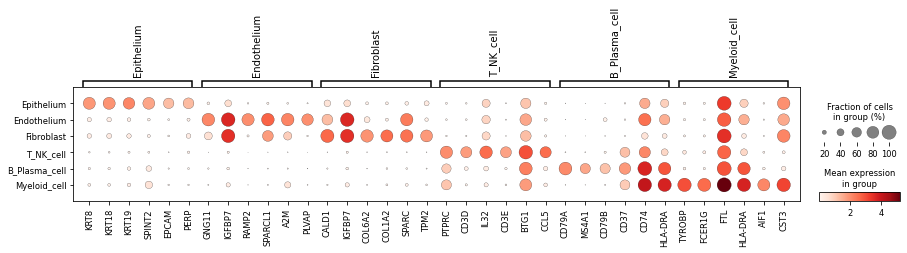

In [5]:
#Extended data Fig3d
sc.pl.dotplot(adata, marker_genes, use_raw=False,groupby='Celltype1',
              save='Extend_Fig3c_marker_gene_dotplot.pdf')

# UMAP for All

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


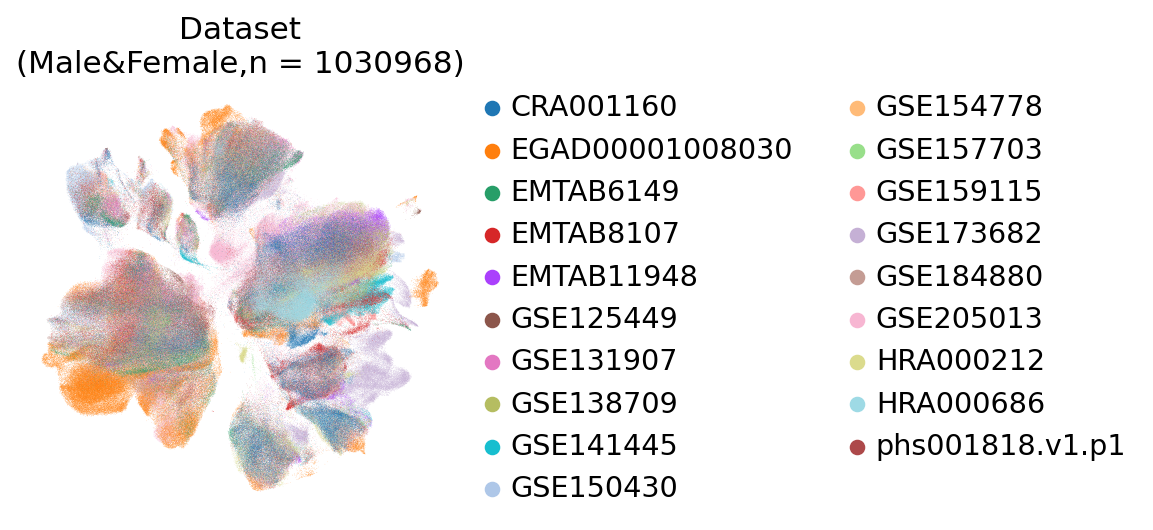

In [57]:
#Extended Data Fig3b Datasets
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["DataID"],
    frameon=False,
    ncols=1,
    title=f'Dataset\n(Male&Female,n = {adata.obs.shape[0]})',
    save='Extend_Fig3c_Datasets_UMAP.pdf'
)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


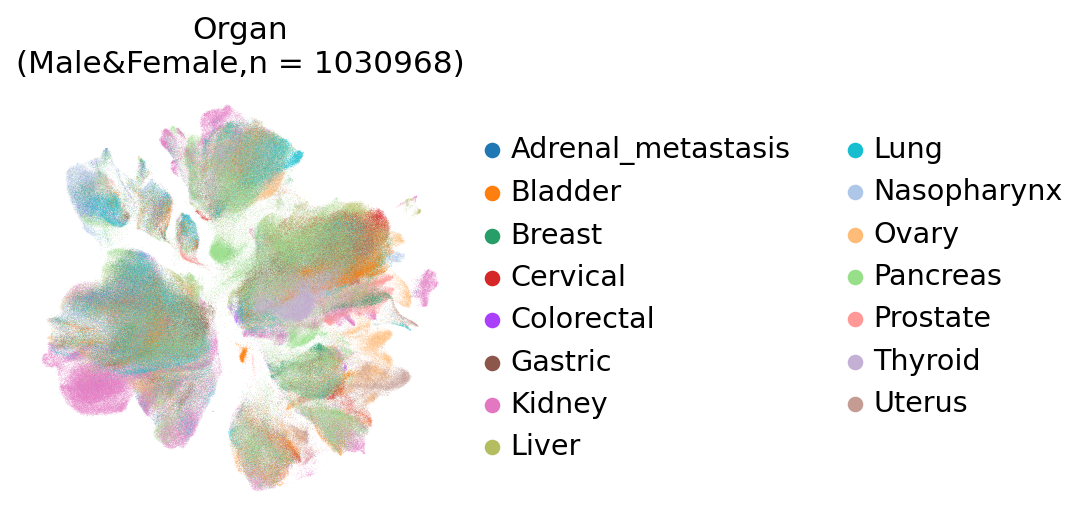

In [58]:
#Extended Data Fig3b Organ
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Organ"],
    frameon=False,
    ncols=1,
    title=f'Organ\n(Male&Female,n = {adata.obs.shape[0]})',
    save='Extend_Fig3c_Organ_UMAP.pdf'
)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


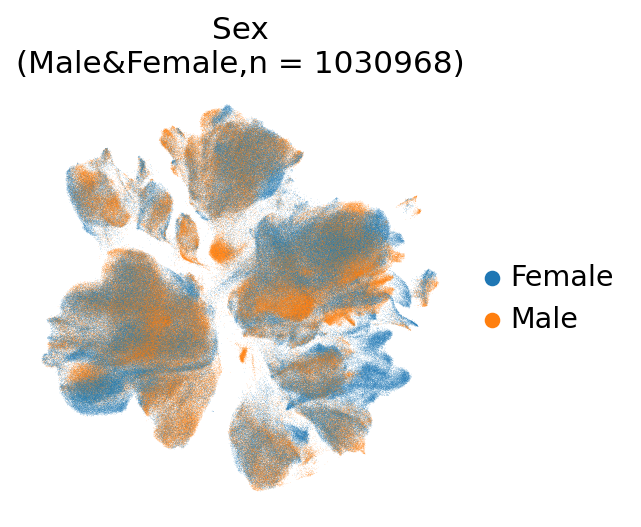

In [59]:
#Extended Data Fig3b Sex
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Sex"],
    frameon=False,
    ncols=1,
    title=f'Sex\n(Male&Female,n = {adata.obs.shape[0]})',
    save='Extend_Fig3c_Sex_UMAP.pdf'
)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


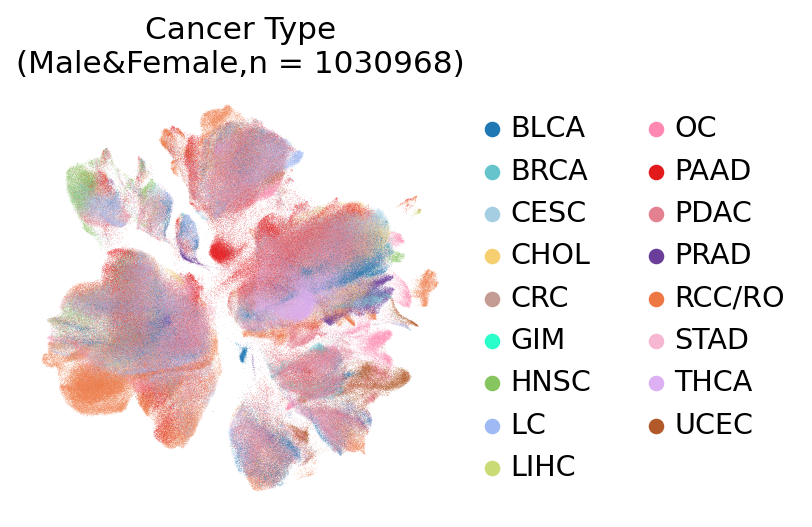

In [10]:
#Extended Data Fig3b Cancertype
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Cancertype_TCGA"],
    frameon=False,
    ncols=1,
    palette = {
      'BLCA': '#1f78b4',
      'BRCA': '#66C5CC',
      'CHOL': '#F6CF71',
      'CRC': '#C49C94',
      'CESC': '#a6cee3',
      'THCA': '#DCB0F2',
      'HNSC': '#87C55F',
      'LC': '#9EB9F3',
      'OC':'#FE88B1',
      'LIHC': '#C9DB74',
      'PAAD':  '#e31a1c',
      'PDAC': "#E38191",
      'PRAD': '#6a3d9a',
      'RCC/RO': '#ed7843',
      'STAD': '#F7B6D2',
      'UCEC': '#b15928',
      'GIM':'#2affcc'
      
    },
    title=f'Cancer Type\n(Male&Female,n = {adata.obs.shape[0]})',
    save='Extend_Fig3c_Cancertype_UMAP.pdf'
)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


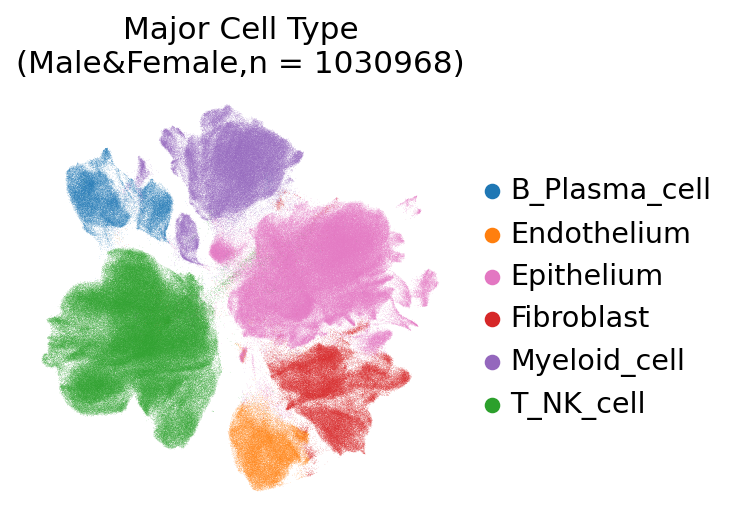

In [6]:
Celltype1_cmap = {
    'B_Plasma_cell':'#1F77B4',
    'Endothelium':'#FF7F0E',
    'Epithelium': '#E377C2',
    'Fibroblast':'#D62728',
    'Myeloid_cell':'#9467BD',
    'T_NK_cell':'#2CA02C',
}
#Extended Data Fig3b Cancertype
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Celltype1"],
    palette=Celltype1_cmap,
    frameon=False,
    ncols=1,
    title=f'Major Cell Type\n(Male&Female,n = {adata.obs.shape[0]})',
    save='Extend_Fig3c_Celltype_UMAP.pdf'
)

# Reference select

In [13]:
import random
indexes = []
for ct in adata.obs['Celltype3'].unique():
    sub_ind = adata.obs_names[adata.obs['Celltype3'] == ct].tolist()
    if len(sub_ind)>2000:
        sub_ind = random.sample(sub_ind,2000)
    
    indexes = indexes + sub_ind

In [14]:
adata_ref = adata[indexes,:].copy()
adata_ref

AnnData object with n_obs × n_vars = 73485 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'Celltype3_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [19]:
adata_ref.write_h5ad('scRNAseq_pancan_ref_2000.h5ad',compression='gzip')